In [1]:
"Option pricing models"

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import sparse
import scipy.linalg as linalg
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad
from scipy.interpolate import RectBivariateSpline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# --- 1. Define Heston Model Parameters and Option Details ---

# Model parameters
v0 = 0.04       # Initial variance (20% volatility)
theta = 0.04    # Long-run variance
kappa = 2.0     # Speed of mean reversion
sigma = 0.3     # Volatility of variance
rho = -0.7      # Correlation between asset and variance (typically negative)
#Market parameters
S0 = 100.0      # Initial stock price
K = 80.0        # Strike price
T = 1.0         # Time to maturity (1 year)
r = 0.03        # Risk-free rate (3%)
q = 0.02        # Dividend yield (2%)


In [3]:
# --- 2. Define the Heston Characteristic Function ---

def char_func_heston(u, T, r, v0, theta, kappa, sigma, rho, stable=True):
    
    if stable==True:
        """
        Computes the Heston characteristic function using a numerically stable formulation
        """
        # This version uses hyperbolic functions for improved numerical stability
        # Numerically stable calculation of C and D

        i = 1j  # Imaginary unit
        
        # Common terms
        beta = kappa - rho * sigma * i * u
        d = np.sqrt(beta**2 + sigma**2 * (u**2 + i * u))
        d_t_half = d * T / 2.0
        
        # Handle the case where d_t_half is very small to avoid division by zero in sinh
        # For small x, sinh(x) approx x and cosh(x) approx 1
        # This prevents NaN values for u=0
        small_d_mask = np.abs(d_t_half) < 1e-10
        
        # Calculate sinh and cosh safely
        sinh_d_tau_half = np.sinh(d_t_half)
        cosh_d_tau_half = np.cosh(d_t_half)
        # Note: coth(x) = 1/tanh(x) = cosh(x)/sinh(x)
        """
        # Avoid numerical issues when d*T is very small
        if np.abs(d_half_T) < 1e-8:
            # Use Taylor expansion for small arguments
            sinh_d_tau_half = d_t_half * (1 + (d_t_half)**2 / 6)
            cosh_d_tau_half = 1 + (d_t_half)**2 / 2
        else:
            sinh_d_tau_half = np.sinh(d_t_half)
            cosh_d_tau_half = np.cosh(d_t_half)
        """

        # D term
        # When d is small, d*coth(d*T/2) -> 2/T
        D_val = -(u**2 + i * u) / (beta + d * cosh_d_tau_half / sinh_d_tau_half)
        D_val[small_d_mask] = -(u[small_d_mask]**2 + i * u[small_d_mask]) / (beta[small_d_mask] + 2.0/T)

        # C term
        # When d is small, the log term simplifies
        log_term = cosh_d_tau_half + (beta / d) * sinh_d_tau_half
        log_term[small_d_mask] = 1.0 # Log(1)=0, so the term vanishes
        
        C_val = (kappa * theta / sigma**2) * (beta * T - 2 * np.log(log_term))

        # The characteristic function
        phi = np.exp(C_val + D_val * v0 + i * u * (np.log(S0) + r * T))
    
    else:
        """
        Computes the Heston characteristic function
        """
        i = 1j  # Imaginary unit
        
        # Calculate d and g
        beta = kappa - rho * sigma * i * u
        d = np.sqrt((rho * sigma * i * u - kappa)**2 + sigma**2 * (u**2 + i * u))
        g = (beta - d) / (beta + d)

        # Calculate C and D
        C = ((kappa * theta / sigma**2) * ((beta - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g))))
        D = ((beta - d) / sigma**2) * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))

        # The characteristic function
        phi = np.exp(C + D * v0 + (i * u) * (r * T + np.log(S0)))
        
    return phi

# --- 3. Implement the FFT-based Pricing Method ---
# This function calls the stable characteristic function

def price_call_heston_fft(S0, T, r, v0, theta, kappa, sigma, rho, N = 2**12, eta = 0.25, alpha = 1.5, simpson=True):
    """
    Prices European call options using the Heston model and FFT.
    Returns a range of strikes and their corresponding call prices.

    K: Strike price
    T: Time to maturity
    N: Number of points for FFT
    alpha: Damping parameter
    # FFT parameters
    N = 2**12             # Number of points, should be a power of 2
    alpha = 1.5           # Dampening factor for integrability
    eta = 0.25            # Grid spacing in Fourier domain
    """

    i = 1j  # Imaginary unit
    lambda_ = (2 * np.pi) / (N * eta)  # Step-size in log strike space

    # Grids
    v = np.arange(N) * eta # Integration points
    #k = np.log(S0) - (N / 2) * lambda_ + np.arange(N) * lambda_  # Strike price range
    k = -(N * lambda_ / 2) + lambda_ * np.arange(N)
    strikes = np.exp(k)
    
    # Calculate the Fourier transform of the call price
    u_for_psi = v - (alpha + 1) * i
    numerator = np.exp(-r * T) * char_func_heston(u_for_psi, T, r, v0, theta, kappa, sigma, rho)
    denominator = (alpha + i * v) * (alpha + 1 + i * v)
    psi = numerator / denominator # Damping function

    if simpson == True:
        # Simpson's rule weights
        # Apply Simpson's rule weighting for better accuracy
        simpson_weights = (eta / 3) * (3 + (-1)**(np.arange(N) + 1) - (np.arange(N) == 0))
        fft_input = np.exp(i * v * (N / 2) * lambda_) * psi * simpson_weights
            
    else:
        eta = np.full(N, eta)
        fft_input = np.exp(i * v * (N / 2) * lambda_) * psi * eta

    # FFT
    call_prices_fft = np.fft.fft(fft_input)
    
    call_prices = np.exp(-alpha * k) / np.pi * np.real(call_prices_fft)
    #call_prices = np.exp(-alpha * k) * np.real(call_prices_fft) / np.pi
    
    return strikes, call_prices


In [ ]:
# --- 4. Calibrate the model parameters using ---

In [49]:
# --- 4. Price the option and visualize the results ---

maturities = np.linspace((1/52), 2.0, 104)
prices = np.zeros((2**12, len(maturities)))

for n, T in enumerate(maturities):
    strikes, call_prices = price_call_heston_fft(S0, T, r, v0, theta, kappa, sigma, rho)
    prices[:, n] = np.array(call_prices)


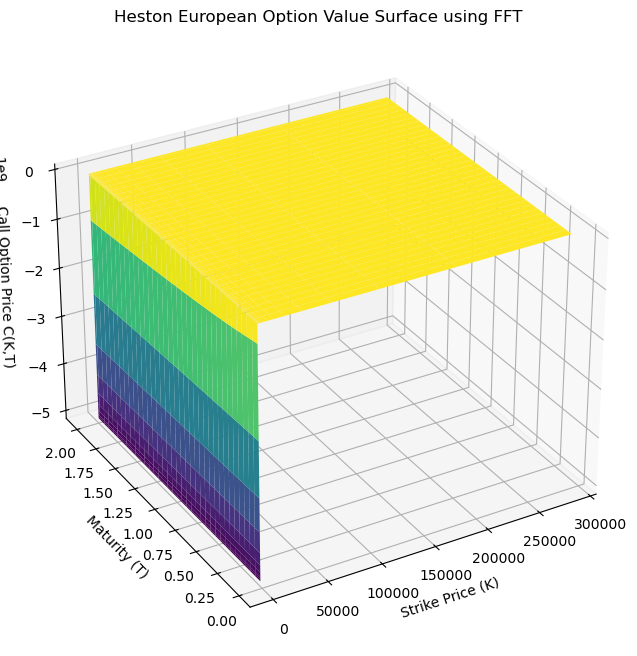

In [ ]:
# --- 4. Price the option and visualize the results ---

maturities = np.linspace((1/52), 2.0, 104)
prices = np.zeros((2**12, len(maturities)))

for n, T in enumerate(maturities):
    strikes, call_prices = price_call_heston_fft(S0, T, r, v0, theta, kappa, sigma, rho)
    prices[:, n] = np.array(call_prices)

# --- 5. Visualize the American Put Option Value Surface ---
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
strikes, maturities = np.meshgrid(strikes, maturities, indexing='ij')

ax.plot_surface(strikes, maturities, prices, cmap='viridis')
ax.set_title("Heston European Option Value Surface using FFT")
ax.set_xlabel("Strike Price (K)")
ax.set_ylabel("Maturity (T)")
ax.set_zlabel("Call Option Price C(K,T)")
#ax.set_xlim(0, 200)
#ax.set_ylim(0, 2)
#ax.set_zlim(0, 30)
ax.view_init(30, -120)
plt.show()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(strikes, call_prices, label='Heston FFT Call Prices (Stable)', color='navy')
plt.axvline(x=S0, color='r', linestyle='--', label=f'Initial Stock Price (S0={S0})')
plt.xlabel('Strike Price (K)')
plt.ylabel('Call Option Price')
plt.title('Heston Model European Call Prices via FFT (Stable Formulation)')
plt.grid(True)
plt.legend()
plt.xlim([50, 150])
plt.ylim([0, 55])
plt.show()


Heston Model Parameters:
v0=0.04, theta=0.04, kappa=2.0, sigma=0.3, rho=-0.7, r=0.03, T=1.0

Price for an at-the-money (K=100) call option: 9.2434


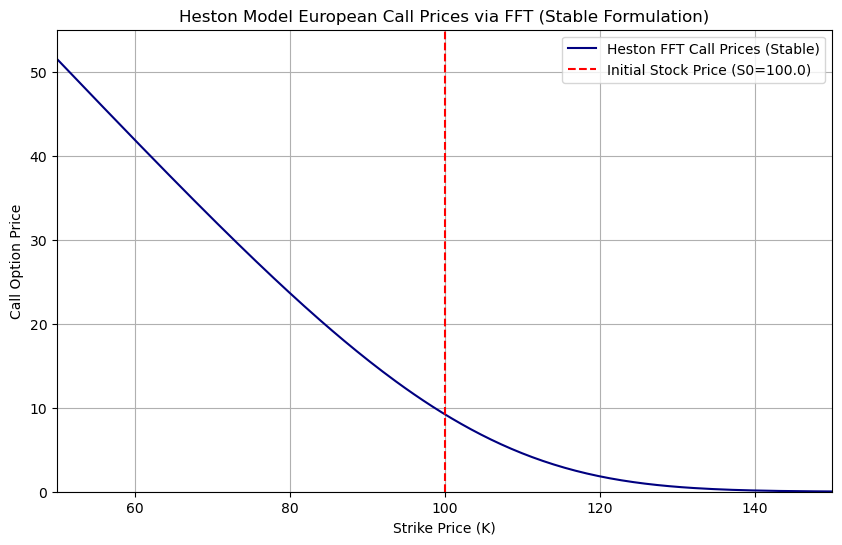

In [ ]:
# --- 4. Price the option and visualize the results ---

prices = np.zeros(2**12, len(T))

for t in T:
    strikes, call_prices = price_call_heston_fft(S0, T, r, v0, theta, kappa, sigma, rho)

if __name__ == '__main__':
    # Get the prices for a range of strikes using the stable method
    strikes, call_prices = price_call_heston_fft(S0, T, r, v0, theta, kappa, sigma, rho)
    
    # Find the price for an at-the-money strike (K=100)
    atm_strike = 100
    atm_price = np.interp(atm_strike, strikes, call_prices)
    print(f"Heston Model Parameters:")
    print(f"v0={v0}, theta={theta}, kappa={kappa}, sigma={sigma}, rho={rho}, r={r}, T={T}\n")
    print(f"Price for an at-the-money (K={atm_strike}) call option: {atm_price:.4f}")

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(strikes, call_prices, label='Heston FFT Call Prices (Stable)', color='navy')
    plt.axvline(x=S0, color='r', linestyle='--', label=f'Initial Stock Price (S0={S0})')
    plt.xlabel('Strike Price (K)')
    plt.ylabel('Call Option Price')
    plt.title('Heston Model European Call Prices via FFT (Stable Formulation)')
    plt.grid(True)
    plt.legend()
    plt.xlim([50, 150])
    plt.ylim([0, 55])
    plt.show()

Heston Model Parameters:
v0=0.04, theta=0.04, kappa=2.0, sigma=0.3, rho=-0.7, r=0.03, T=1.0

Price for an at-the-money (K=100) call option: 9.2434


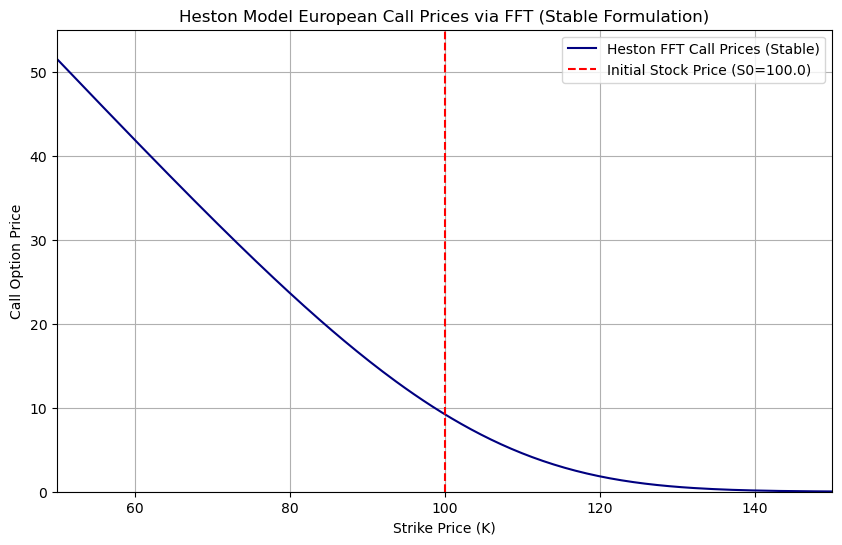

In [ ]:
# --- 4. Price the option and visualize the results ---

if __name__ == '__main__':
    # Get the prices for a range of strikes using the stable method
    strikes, call_prices = price_call_heston_fft(S0, T, r, v0, theta, kappa, sigma, rho)
    
    # Find the price for an at-the-money strike (K=100)
    atm_strike = 100
    atm_price = np.interp(atm_strike, strikes, call_prices)
    print(f"Heston Model Parameters:")
    print(f"v0={v0}, theta={theta}, kappa={kappa}, sigma={sigma}, rho={rho}, r={r}, T={T}\n")
    print(f"Price for an at-the-money (K={atm_strike}) call option: {atm_price:.4f}")

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(strikes, call_prices, label='Heston FFT Call Prices (Stable)', color='navy')
    plt.axvline(x=S0, color='r', linestyle='--', label=f'Initial Stock Price (S0={S0})')
    plt.xlabel('Strike Price (K)')
    plt.ylabel('Call Option Price')
    plt.title('Heston Model European Call Prices via FFT (Stable Formulation)')
    plt.grid(True)
    plt.legend()
    plt.xlim([50, 150])
    plt.ylim([0, 55])
    plt.show()

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(strikes, call_prices, label='Heston FFT Call Prices (Stable)', color='navy')
    plt.axvline(x=S0, color='r', linestyle='--', label=f'Initial Stock Price (S0={S0})')
    plt.xlabel('Strike Price (K)')
    plt.ylabel('Call Option Price')
    plt.title('Heston Model European Call Prices via FFT (Stable Formulation)')
    plt.grid(True)
    plt.legend()
    plt.xlim([50, 150])
    plt.ylim([0, 55])
    plt.show()

    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    #S_mat, v_mat = np.meshgrid(S_grid, v_grid, indexing='ij')

    ax.plot_surface(S_mat, v_mat, V_grid, cmap='viridis')
    ax.set_title("Heston American Put Option Value Surface (Solved with spsolve)")
    ax.set_xlabel("Stock Price (S)")
    ax.set_ylabel("Variance (v)")
    ax.set_zlabel("Option Price")
    ax.view_init(30, -120)
    plt.show()

In [17]:
# --- 1. Main Pricing Function using ADI Method ---

def price_american_put_heston_adi(S0, K, T, r, v0, theta, kappa, sigma, rho, N_S = 500, N_v = 100, N_t = 100, S_max=None):
    """
    Prices an American put option using the Heston model via an ADI finite difference method
    """

    # Define the Finite Difference Grid
    # Grid parameters
    # N_S = 500       # Number of stock price steps
    # N_v = 100        # Number of variance steps
    # N_t = 100       # Number of time steps

    # Grid boundaries
    if S_max is None:
        #S_max = 2 * max(S0, K)   # Max stock price
        S_max = 2 * S0   # Max stock price
    v_max = 0.5      # Max variance

    # Create grids
    S_grid = np.linspace(0, S_max, N_S + 1)
    v_grid = np.linspace(0, v_max, N_v + 1)
    t_grid = np.linspace(0, T, N_t + 1)

    dS = S_grid[1] - S_grid[0]
    dv = v_grid[1] - v_grid[0]
    dt = t_grid[1] - t_grid[0]
    
    # Initialize option value grid at maturity
    # V = np.zeros((N_S + 1, N_v + 1))
    S_mat, v_mat = np.meshgrid(S_grid, v_grid, indexing='ij')
    V = np.maximum(K - S_mat, 0)
    
    # --- Time Marching Loop (from T to 0) ---
    for n in range(N_t, 0, -1):
        # -- Intermediate Step (Y) --
        # Implicit in S, Explicit in v
        
        # Temporary grid for intermediate values
        Y = np.zeros_like(V)
        
        # Loop over interior variance points
        for j in range(1, N_v):
            vj = v_grid[j]
            
            # Coefficients for the S-dimension PDE part
            lower_S = (dt / 2) * ((vj / 2) * S_grid[1:-1]**2 / dS**2 - r * S_grid[1:-1] / (2 * dS))
            main_S = -(dt / 2) * (vj * S_grid[1:-1]**2 / dS**2 + r)
            upper_S = (dt / 2) * ((vj / 2) * S_grid[1:-1]**2 / dS**2 + r * S_grid[1:-1] / (2 * dS))

            # --- Create A_S as a sparse matrix using diags ---
            diagonals_S = [-lower_S[1:], 1 - main_S, -upper_S[:-1]]
            offsets = [-1, 0, 1]
            A_S_sparse = diags(diagonals_S, offsets, shape=(N_S - 1, N_S - 1), format='csc')
            
            # Setup RHS (Right-Hand Side)
            B_S_V = (V[1:-1, j] + 
                     lower_S * V[:-2, j] + 
                     main_S * V[1:-1, j] + 
                     upper_S * V[2:, j])
            
            # RHS vector from explicit v-parts and cross-derivative


            dv_V = (V[1:-1, j+1] - V[1:-1, j-1]) / (2 * dv)
            d2v_V = (V[1:-1, j+1] - 2 * V[1:-1, j] + V[1:-1, j-1]) / dv**2
            dSv_V = (V[2:, j+1] - V[:-2, j+1] - V[2:, j-1] + V[:-2, j-1]) / (4 * dS * dv)

            L_v_V = (0.5 * sigma**2 * vj * d2v_V + 
                     kappa * (theta - vj) * dv_V +
                     0.5 * rho * sigma * vj * S_grid[1:-1] * dSv_V)
            
            rhs = B_S_V + dt * L_v_V

            rhs[0] += 2 * lower_S[0] * K 
            rhs[-1] += 2 * upper_S[-1] * 0
            
            # Solve using spsolve
            Y[1:-1, j] = spsolve(A_S_sparse, rhs)

        # Apply boundary conditions for Y
        Y[0, :] = K
        Y[-1, :] = 0
        Y[:, 0] = K * np.exp(-r * (T - t_grid[n-1])) # Feller condition at v=0
        Y[:, -1] = Y[:, -2] # Extrapolate at v_max
        
        # -- Final Step (V) --
        # Implicit in v, Explicit in S (using Y values)
        
        # Loop over interior stock price points
        for i in range(1, N_S):
            Si = S_grid[i]
            
            # Coefficients for the v-dimension PDE part
            lower_v = (dt / 2) * ((sigma**2 / 2) * v_grid[1:-1] / dv**2 - kappa * (theta - v_grid[1:-1]) / (2 * dv))
            main_v = -(dt / 2) * (sigma**2 * v_grid[1:-1] / dv**2 + r)
            upper_v = (dt / 2) * ((sigma**2 / 2) * v_grid[1:-1] / dv**2 + kappa * (theta - v_grid[1:-1]) / (2 * dv))
            
            # --- Create A_v as a sparse matrix using diags ---
            diagonals_v = [-lower_v[1:], 1 - main_v, -upper_v[:-1]]
            offsets_v = [-1, 0, 1]
            A_v_sparse = diags(diagonals_v, offsets_v, shape=(N_v - 1, N_v - 1), format='csc')

            # Get the explicit S-part from the intermediate solution Y
            dS_Y = (Y[i+1, 1:-1] - Y[i-1, 1:-1]) / (2 * dS)
            d2S_Y = (Y[i+1, 1:-1] - 2 * Y[i, 1:-1] + Y[i-1, 1:-1]) / dS**2
            
            # We subtract the explicit part that was already added in the Y step
            L_S_V = 0.5 * v_grid[1:-1] * Si**2 * d2S_Y + r * Si * dS_Y - 0.5 * r * V[i, 1:-1]
            L_S_Y = 0.5 * v_grid[1:-1] * Si**2 * d2S_Y + r * Si * dS_Y - 0.5 * r * Y[i, 1:-1]

             # B_v_V is the explicit part for the v-direction
            B_v_V = V[i, 1:-1] + lower_v*V[i, :-2] + main_v*V[i, 1:-1] + upper_v*V[i, 2:]
            
            rhs_v = B_v_V + (L_S_Y - L_S_V)

            # Boundary conditions for v-direction
            rhs_v[0] += 2 * lower_v[0] * (K * np.exp(-r * (T - t_grid[n-1])) - Y[i,0])
            # No specific condition for v_max, natural boundary
            
            # Solve using spsolve
            V[i, 1:-1] = spsolve(A_v_sparse, rhs_v)
            
        # --- Enforce American Early Exercise Constraint ---
        intrinsic_value = np.maximum(K - S_mat, 0)
        V = np.maximum(V, intrinsic_value)

    # --- Interpolate to find the price at (S0, v0) ---
    spline = RectBivariateSpline(S_grid, v_grid, V)
    price = spline(S0, v0)[0][0]
    
    return price, V


In [36]:
# --- 1. Main Pricing Function using ADI Method --

def price_american_put_heston_spsolve(S0, K, T, r, v0, theta, kappa, sigma, rho,
                                      N_S = 500, N_v = 100, N_t = 100, S_max=None):
    """
    Prices an American put option using the Heston model,
    solving the linear systems with scipy.sparse.linalg.spsolve.
    """
    # Define the Finite Difference Grid
    # Grid parameters
    # N_S = 500       # Number of stock price steps
    # N_v = 100       # Number of variance steps
    # N_t = 100       # Number of time steps

    # Grid boundaries
    if S_max is None:
        #S_max = 2 * max(S0, K)   # Max stock price
        S_max = 2 * S0   # Max stock price
    v_max = 0.5      # Max variance

    S_grid = np.linspace(0, S_max, N_S + 1)
    v_grid = np.linspace(0, v_max, N_v + 1)
    t_grid = np.linspace(0, T, N_t + 1)

    dS = S_grid[1] - S_grid[0]
    dv = v_grid[1] - v_grid[0]
    dt = t_grid[1] - t_grid[0]
    
    #V = np.zeros((N_S + 1, N_v + 1))
    S_mat, v_mat = np.meshgrid(S_grid, v_grid, indexing='ij')
    V = np.maximum(K - S_mat, 0)
    
    for n in range(N_t, 0, -1):
        # -- Intermediate Step (Y) --
        Y = np.zeros_like(V)
        
        for j in range(1, N_v):
            vj = v_grid[j]
            
            alpha_S = 0.25 * dt * (vj * S_grid[1:-1]**2 / dS**2 - r * S_grid[1:-1] / dS)
            beta_S = -0.5 * dt * (vj * S_grid[1:-1]**2 / dS**2 + r)
            gamma_S = 0.25 * dt * (vj * S_grid[1:-1]**2 / dS**2 + r * S_grid[1:-1] / dS)
            
            # --- FIX 1: Create A_S as a sparse matrix using diags ---
            diagonals_S = [-alpha_S[1:], 1 - beta_S, -gamma_S[:-1]]
            offsets = [-1, 0, 1]
            A_S_sparse = diags(diagonals_S, offsets, shape=(N_S - 1, N_S - 1), format='csc')
            
            # Setup RHS (Right-Hand Side)
            B_S_V = (V[1:-1, j] + 
                     alpha_S * V[:-2, j] + 
                     beta_S * V[1:-1, j] + 
                     gamma_S * V[2:, j])

            dv_V = (V[1:-1, j+1] - V[1:-1, j-1]) / (2 * dv)
            d2v_V = (V[1:-1, j+1] - 2 * V[1:-1, j] + V[1:-1, j-1]) / dv**2
            dSv_V = (V[2:, j+1] - V[:-2, j+1] - V[2:, j-1] + V[:-2, j-1]) / (4 * dS * dv)

            L_v_V = (0.5 * sigma**2 * vj * d2v_V + kappa * (theta - vj) * dv_V +
                     0.5 * rho * sigma * vj * S_grid[1:-1] * dSv_V)
            
            rhs = B_S_V + dt * L_v_V

            rhs[0] += 2 * alpha_S[0] * K 
            rhs[-1] += 2 * gamma_S[-1] * 0
            
            # Solve using spsolve
            Y[1:-1, j] = spsolve(A_S_sparse, rhs)

        Y[0, :] = K
        Y[-1, :] = 0
        Y[:, 0] = K * np.exp(-r * (T - t_grid[n-1]))
        Y[:, -1] = Y[:, -2]
        
        # -- Final Step (V) --
        for i in range(1, N_S):
            Si = S_grid[i]
            
            alpha_v = 0.25 * dt * (sigma**2 * v_grid[1:-1] / dv**2 - kappa * (theta - v_grid[1:-1]) / dv)
            beta_v = -0.5 * dt * (sigma**2 * v_grid[1:-1] / dv**2 + r)
            gamma_v = 0.25 * dt * (sigma**2 * v_grid[1:-1] / dv**2 + kappa * (theta - v_grid[1:-1]) / dv)

            # --- FIX 2: Create A_v as a sparse matrix using diags ---
            diagonals_v = [-alpha_v[1:], 1 - beta_v, -gamma_v[:-1]]
            offsets_v = [-1, 0, 1]
            A_v_sparse = diags(diagonals_v, offsets_v, shape=(N_v - 1, N_v - 1), format='csc')

            dS_Y = (Y[i+1, 1:-1] - Y[i-1, 1:-1]) / (2 * dS)
            d2S_Y = (Y[i+1, 1:-1] - 2 * Y[i, 1:-1] + Y[i-1, 1:-1]) / dS**2
            
            L_S_V = 0.5 * v_grid[1:-1] * Si**2 * d2S_Y + r * Si * dS_Y - 0.5 * r * V[i, 1:-1]
            L_S_Y = 0.5 * v_grid[1:-1] * Si**2 * d2S_Y + r * Si * dS_Y - 0.5 * r * Y[i, 1:-1]
            
            # B_v_V is the explicit part for the v-direction
            B_v_V = V[i, 1:-1] + alpha_v*V[i, :-2] + beta_v*V[i, 1:-1] + gamma_v*V[i, 2:]
            
            rhs_v = B_v_V + (L_S_Y - L_S_V)
            
            rhs_v[0] += 2 * alpha_v[0] * (K * np.exp(-r * (T - t_grid[n-1])) - Y[i,0])
            
            # Solve using spsolve
            V[i, 1:-1] = spsolve(A_v_sparse, rhs_v)
            
        intrinsic_value = np.maximum(K - S_mat, 0)
        V = np.maximum(V, intrinsic_value)

    spline = RectBivariateSpline(S_grid, v_grid, V)
    price = spline(S0, v0)[0][0]
    
    return price, V


Heston Model Parameters:
v0=0.04, theta=0.04, kappa=2.0, sigma=0.3, rho=-0.7, r=0.05, T=1.0

Grid Size: 150 (Stock Price) x 50 (Variance) x 100 (Time)
Price for an at-the-money (S0=100.0, K=100.0) American Put Option: 0.0000


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (101, 51) and arg 2 with shape (501, 101).

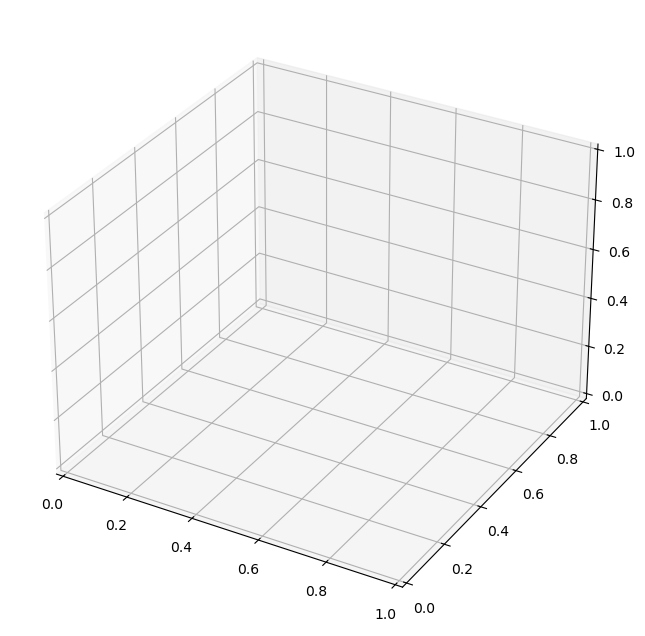

In [37]:
# --- 2. Define Heston Model Parameters and Option Details ---
v0 = 0.04       # Initial variance
theta = 0.04    # Long-run variance
kappa = 2.0     # Speed of mean reversion
sigma = 0.3     # Volatility of variance
rho = -0.7      # Correlation
S0 = 100.0      # Initial stock price
K = 100.0       # Strike price
T = 1.0         # Time to maturity (1 year)
r = 0.05        # Risk-free rate

# --- 3. Price the option and visualize the results ---
if __name__ == '__main__':
    price, V_grid = price_american_put_heston_spsolve(S0, K, T, r, v0, theta, kappa, sigma, rho)
    
    print(f"Heston Model Parameters:")
    print(f"v0={v0}, theta={theta}, kappa={kappa}, sigma={sigma}, rho={rho}, r={r}, T={T}\n")
    print(f"Grid Size: {N_S} (Stock Price) x {N_v} (Variance) x {N_t} (Time)")
    print(f"Price for an at-the-money (S0={S0}, K={K}) American Put Option: {price:.4f}")

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    S_mat, v_mat = np.meshgrid(S_grid, v_grid, indexing='ij')

    ax.plot_surface(S_mat, v_mat, V_grid, cmap='viridis')
    ax.set_title("Heston American Put Option Value Surface (Solved with spsolve)")
    ax.set_xlabel("Stock Price (S)")
    ax.set_ylabel("Variance (v)")
    ax.set_zlabel("Option Price")
    ax.view_init(30, -120)
    plt.show()

In [3]:
import numpy as np
import scipy.linalg as linalg
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Define Heston Model Parameters and Option Details ---
v0 = 0.04       # Initial variance
theta = 0.04    # Long-run variance
kappa = 2.0     # Speed of mean reversion
sigma = 0.3     # Volatility of variance
rho = -0.7      # Correlation
S0 = 100.0      # Initial stock price
K = 100.0       # Strike price
T = 1.0         # Time to maturity (1 year)
r = 0.05        # Risk-free rate

# --- 2. Define the Finite Difference Grid ---
N_S = 100       # Number of stock price steps
N_v = 50        # Number of variance steps
N_t = 100       # Number of time steps
S_max = 2 * S0   # Max stock price
v_max = 0.5      # Max variance

S_grid = np.linspace(0, S_max, N_S + 1)
v_grid = np.linspace(0, v_max, N_v + 1)
t_grid = np.linspace(0, T, N_t + 1)

dS = S_grid[1] - S_grid[0]
dv = v_grid[1] - v_grid[0]
dt = t_grid[1] - t_grid[0]

# --- 3. Main Pricing Function with CORRECTED RHS calculation ---
def price_american_put_heston_adi_corrected(S0, K, T, r, v0, theta, kappa, sigma, rho,
                                            S_grid, v_grid, t_grid):
    """
    Prices an American put option using the Heston model via an ADI finite difference method.
    This version corrects the RHS calculation to resolve the broadcasting error.
    """
    N_S = len(S_grid) - 1
    N_v = len(v_grid) - 1
    N_t = len(t_grid) - 1
    
    V = np.zeros((N_S + 1, N_v + 1))
    S_mat, v_mat = np.meshgrid(S_grid, v_grid, indexing='ij')
    V = np.maximum(K - S_mat, 0)
    
    for n in range(N_t, 0, -1):
        # -- Intermediate Step (Y) --
        Y = np.zeros_like(V)
        
        for j in range(1, N_v):
            vj = v_grid[j]
            
            alpha_S = 0.25 * dt * (vj * S_grid[1:-1]**2 / dS**2 - r * S_grid[1:-1] / dS)
            beta_S = -0.5 * dt * (vj * S_grid[1:-1]**2 / dS**2 + r)
            gamma_S = 0.25 * dt * (vj * S_grid[1:-1]**2 / dS**2 + r * S_grid[1:-1] / dS)
            
            ab_S = np.zeros((3, N_S - 1))
            ab_S[0, 1:] = -gamma_S[:-1]
            ab_S[1, :] = 1 - beta_S
            ab_S[2, :-1] = -alpha_S[1:]

            dv_V = (V[1:-1, j+1] - V[1:-1, j-1]) / (2 * dv)
            d2v_V = (V[1:-1, j+1] - 2 * V[1:-1, j] + V[1:-1, j-1]) / dv**2
            dSv_V = (V[2:, j+1] - V[:-2, j+1] - V[2:, j-1] + V[:-2, j-1]) / (4 * dS * dv)

            L_v_V = (0.5 * sigma**2 * vj * d2v_V + kappa * (theta - vj) * dv_V +
                     0.5 * rho * sigma * vj * S_grid[1:-1] * dSv_V)
            
            # --- FIX 1: Corrected RHS calculation for the S-direction ---
            # This is the explicit part (I + dt/2 * L_S)V applied to the grid
            rhs = (alpha_S * V[:-2, j] + (1 + beta_S) * V[1:-1, j] + gamma_S * V[2:, j]) + dt * L_v_V

            rhs[0] += 2 * alpha_S[0] * K 
            rhs[-1] += 2 * gamma_S[-1] * 0
            
            Y[1:-1, j] = linalg.solve_banded((1, 1), ab_S, rhs)

        Y[0, :] = K
        Y[-1, :] = 0
        Y[:, 0] = K * np.exp(-r * (T - t_grid[n-1]))
        Y[:, -1] = Y[:, -2]
        
        # -- Final Step (V) --
        for i in range(1, N_S):
            Si = S_grid[i]
            
            alpha_v = 0.25 * dt * (sigma**2 * v_grid[1:-1] / dv**2 - kappa * (theta - v_grid[1:-1]) / dv)
            beta_v = -0.5 * dt * (sigma**2 * v_grid[1:-1] / dv**2 + r)
            gamma_v = 0.25 * dt * (sigma**2 * v_grid[1:-1] / dv**2 + kappa * (theta - v_grid[1:-1]) / dv)

            ab_v = np.zeros((3, N_v - 1))
            ab_v[0, 1:] = -gamma_v[:-1]
            ab_v[1, :] = 1 - beta_v
            ab_v[2, :-1] = -alpha_v[1:]

            dS_Y = (Y[i+1, 1:-1] - Y[i-1, 1:-1]) / (2 * dS)
            d2S_Y = (Y[i+1, 1:-1] - 2 * Y[i, 1:-1] + Y[i-1, 1:-1]) / dS**2
            
            # The change in the explicit S-operator part from Y to V
            L_S_Y_minus_L_S_V = (0.5 * v_grid[1:-1] * Si**2 * (d2S_Y - (V[i+1, 1:-1] - 2*V[i, 1:-1] + V[i-1, 1:-1])/dS**2) +
                                 r * Si * (dS_Y - (V[i+1, 1:-1] - V[i-1, 1:-1])/(2*dS)) -
                                 0.5 * r * (Y[i, 1:-1] - V[i, 1:-1]))
            
            # --- FIX 2: Corrected RHS calculation for the v-direction ---
            rhs_v = (alpha_v * V[i, :-2] + (1 + beta_v) * V[i, 1:-1] + gamma_v * V[i, 2:]) + L_S_Y_minus_L_S_V

            rhs_v[0] += 2 * alpha_v[0] * (K * np.exp(-r * (T - t_grid[n-1])) - Y[i,0])
            
            V[i, 1:-1] = linalg.solve_banded((1, 1), ab_v, rhs_v)
            
        intrinsic_value = np.maximum(K - S_mat, 0)
        V = np.maximum(V, intrinsic_value)

    spline = RectBivariateSpline(S_grid, v_grid, V)
    price = spline(S0, v0)[0][0]
    
    return price, V

# --- 4. Price the option and visualize the results ---
if __name__ == '__main__':
    price, V_grid = price_american_put_heston_adi_corrected(S0, K, T, r, v0, theta, kappa, sigma, rho,
                                                            S_grid, v_grid, t_grid)
    
    print(f"Heston Model Parameters:")
    print(f"v0={v0}, theta={theta}, kappa={kappa}, sigma={sigma}, rho={rho}, r={r}, T={T}\n")
    print(f"Grid Size: {N_S} (Stock Price) x {N_v} (Variance) x {N_t} (Time)")
    print(f"Price for an at-the-money (S0={S0}, K={K}) American Put Option: {price:.4f}")

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    S_mat, v_mat = np.meshgrid(S_grid, v_grid, indexing='ij')

    ax.plot_surface(S_mat, v_mat, V_grid, cmap='viridis')
    ax.set_title("Heston American Put Option Value Surface")
    ax.set_xlabel("Stock Price (S)")
    ax.set_ylabel("Variance (v)")
    ax.set_zlabel("Option Price")
    ax.view_init(30, -120)
    plt.show()

C:\Users\lukas\AppData\Local\Temp\ipykernel_1164\3807913383.py:102: RuntimeWarning: overflow encountered in multiply
  L_S_Y_minus_L_S_V = (0.5 * v_grid[1:-1] * Si**2 * (d2S_Y - (V[i+1, 1:-1] - 2*V[i, 1:-1] + V[i-1, 1:-1])/dS**2) +


ValueError: array must not contain infs or NaNs

Heston Model Parameters:
v0=0.04, theta=0.04, kappa=2.0, sigma=0.3, rho=-0.7, r=0.05, T=1.0

Grid Size: 100 (Stock Price) x 50 (Variance) x 100 (Time)
Price for an at-the-money (S0=100.0, K=100.0) American Put Option: 0.0000


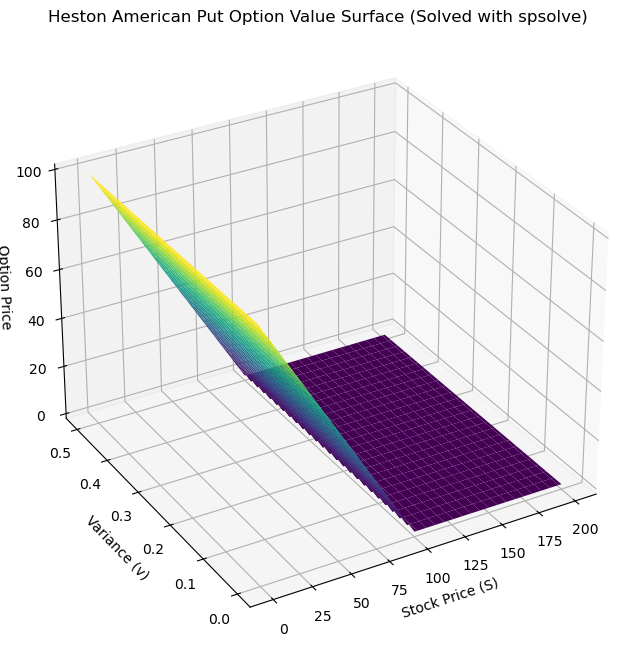

In [40]:
# --- 1. Define Heston Model Parameters and Option Details ---
v0 = 0.04       # Initial variance
theta = 0.04    # Long-run variance
kappa = 2.0     # Speed of mean reversion
sigma = 0.3     # Volatility of variance
rho = -0.7      # Correlation
S0 = 100.0      # Initial stock price
K = 100.0       # Strike price
T = 1.0         # Time to maturity (1 year)
r = 0.05        # Risk-free rate

# --- 2. Define the Finite Difference Grid ---
N_S = 100
N_v = 50
N_t = 100
S_max = 2 * S0
v_max = 0.5

S_grid = np.linspace(0, S_max, N_S + 1)
v_grid = np.linspace(0, v_max, N_v + 1)
t_grid = np.linspace(0, T, N_t + 1)

dS = S_grid[1] - S_grid[0]
dv = v_grid[1] - v_grid[0]
dt = t_grid[1] - t_grid[0]

# --- 3. Main Pricing Function using spsolve ---
def price_american_put_heston_spsolve(S0, K, T, r, v0, theta, kappa, sigma, rho,
                                      S_grid, v_grid, t_grid):
    """
    Prices an American put option using the Heston model,
    solving the linear systems with scipy.sparse.linalg.spsolve.
    """
    N_S = len(S_grid) - 1
    N_v = len(v_grid) - 1
    N_t = len(t_grid) - 1
    
    V = np.zeros((N_S + 1, N_v + 1))
    S_mat, v_mat = np.meshgrid(S_grid, v_grid, indexing='ij')
    V = np.maximum(K - S_mat, 0)
    
    for n in range(N_t, 0, -1):
        # -- Intermediate Step (Y) --
        Y = np.zeros_like(V)
        
        for j in range(1, N_v):
            vj = v_grid[j]
            
            alpha_S = 0.25 * dt * (vj * S_grid[1:-1]**2 / dS**2 - r * S_grid[1:-1] / dS)
            beta_S = -0.5 * dt * (vj * S_grid[1:-1]**2 / dS**2 + r)
            gamma_S = 0.25 * dt * (vj * S_grid[1:-1]**2 / dS**2 + r * S_grid[1:-1] / dS)
            
            # --- FIX 1: Create A_S as a sparse matrix using diags ---
            diagonals_S = [-alpha_S[1:], 1 - beta_S, -gamma_S[:-1]]
            offsets = [-1, 0, 1]
            A_S_sparse = diags(diagonals_S, offsets, shape=(N_S - 1, N_S - 1), format='csc')
            
            # Setup RHS (Right-Hand Side)
            B_S_V = (V[1:-1, j] + 
                     alpha_S * V[:-2, j] + 
                     beta_S * V[1:-1, j] + 
                     gamma_S * V[2:, j])

            dv_V = (V[1:-1, j+1] - V[1:-1, j-1]) / (2 * dv)
            d2v_V = (V[1:-1, j+1] - 2 * V[1:-1, j] + V[1:-1, j-1]) / dv**2
            dSv_V = (V[2:, j+1] - V[:-2, j+1] - V[2:, j-1] + V[:-2, j-1]) / (4 * dS * dv)

            L_v_V = (0.5 * sigma**2 * vj * d2v_V + kappa * (theta - vj) * dv_V +
                     0.5 * rho * sigma * vj * S_grid[1:-1] * dSv_V)
            
            rhs = B_S_V + dt * L_v_V

            rhs[0] += 2 * alpha_S[0] * K 
            rhs[-1] += 2 * gamma_S[-1] * 0
            
            # Solve using spsolve
            Y[1:-1, j] = spsolve(A_S_sparse, rhs)

        Y[0, :] = K
        Y[-1, :] = 0
        Y[:, 0] = K * np.exp(-r * (T - t_grid[n-1]))
        Y[:, -1] = Y[:, -2]
        
        # -- Final Step (V) --
        for i in range(1, N_S):
            Si = S_grid[i]
            
            alpha_v = 0.25 * dt * (sigma**2 * v_grid[1:-1] / dv**2 - kappa * (theta - v_grid[1:-1]) / dv)
            beta_v = -0.5 * dt * (sigma**2 * v_grid[1:-1] / dv**2 + r)
            gamma_v = 0.25 * dt * (sigma**2 * v_grid[1:-1] / dv**2 + kappa * (theta - v_grid[1:-1]) / dv)

            # --- FIX 2: Create A_v as a sparse matrix using diags ---
            diagonals_v = [-alpha_v[1:], 1 - beta_v, -gamma_v[:-1]]
            offsets_v = [-1, 0, 1]
            A_v_sparse = diags(diagonals_v, offsets_v, shape=(N_v - 1, N_v - 1), format='csc')

            dS_Y = (Y[i+1, 1:-1] - Y[i-1, 1:-1]) / (2 * dS)
            d2S_Y = (Y[i+1, 1:-1] - 2 * Y[i, 1:-1] + Y[i-1, 1:-1]) / dS**2
            
            L_S_V = 0.5 * v_grid[1:-1] * Si**2 * d2S_Y + r * Si * dS_Y - 0.5 * r * V[i, 1:-1]
            L_S_Y = 0.5 * v_grid[1:-1] * Si**2 * d2S_Y + r * Si * dS_Y - 0.5 * r * Y[i, 1:-1]
            
            # B_v_V is the explicit part for the v-direction
            B_v_V = V[i, 1:-1] + alpha_v*V[i, :-2] + beta_v*V[i, 1:-1] + gamma_v*V[i, 2:]
            
            rhs_v = B_v_V + (L_S_Y - L_S_V)
            
            rhs_v[0] += 2 * alpha_v[0] * (K * np.exp(-r * (T - t_grid[n-1])) - Y[i,0])
            
            # Solve using spsolve
            V[i, 1:-1] = spsolve(A_v_sparse, rhs_v)
            
        intrinsic_value = np.maximum(K - S_mat, 0)
        V = np.maximum(V, intrinsic_value)

    spline = RectBivariateSpline(S_grid, v_grid, V)
    price = spline(S0, v0)[0][0]
    
    return price, V

# --- 4. Price the option and visualize the results ---
if __name__ == '__main__':
    price, V_grid = price_american_put_heston_spsolve(S0, K, T, r, v0, theta, kappa, sigma, rho,
                                                      S_grid, v_grid, t_grid)
    
    print(f"Heston Model Parameters:")
    print(f"v0={v0}, theta={theta}, kappa={kappa}, sigma={sigma}, rho={rho}, r={r}, T={T}\n")
    print(f"Grid Size: {N_S} (Stock Price) x {N_v} (Variance) x {N_t} (Time)")
    print(f"Price for an at-the-money (S0={S0}, K={K}) American Put Option: {price:.4f}")

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    S_mat, v_mat = np.meshgrid(S_grid, v_grid, indexing='ij')

    ax.plot_surface(S_mat, v_mat, V_grid, cmap='viridis')
    ax.set_title("Heston American Put Option Value Surface (Solved with spsolve)")
    ax.set_xlabel("Stock Price (S)")
    ax.set_ylabel("Variance (v)")
    ax.set_zlabel("Option Price")
    ax.view_init(30, -120)
    plt.show()